In [100]:
import graphviz

import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report


from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC


from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [4]:
matplotlib.rc("font", family = "NanumGothic")
matplotlib.rc("axes", unicode_minus = False )

# 그래디언트 부스팅 (111P)

#### 1. 데이터 구성하기

In [5]:
# 데이터 불러오기
df_raw = pd.read_csv("/home/piai/바탕화면/실습화일/2. Big Data 분석/HMEQ.csv", encoding = "euc-kr")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [6]:
# 결측치 확인
df_raw.isnull().sum(axis = 0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [7]:
# 범주형 변수인 JOB의 결측치는 Other로 입력
df_raw["JOB"].fillna("Other", inplace = True)
# 연속형 데이터는 평균값으로 결측치 대체
df_raw.fillna(df_raw.mean(), inplace = True)

In [8]:
# 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [9]:
# 데이터 구성하기 - 데이터 분할 (7:3)
df_raw_x = df_raw_dummy.drop("BAD", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["BAD"]

df_train_x , df_test_x , df_train_y , df_test_y = train_test_split(\
    df_raw_x , df_raw_y, test_size = 0.3 , random_state = 1234)

print("분할 전 설명변수 데이터 : " , df_raw_x.shape)
print("분할 후 설명변수 데이터 : Train" , df_train_x.shape , "Test" , df_test_x.shape)

분할 전 설명변수 데이터 :  (3748, 18)
분할 후 설명변수 데이터 : Train (2623, 18) Test (1125, 18)


#### 2. 모델 생성

In [10]:
# 기본 옵션으로 모델 생성
gb_uncust = GradientBoostingClassifier(random_state = 1234)
gb_uncust.fit(df_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(gb_uncust.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(gb_uncust.score(df_test_x, df_test_y)))

Accuracy on training set: 0.963
Accuracy on test set: 0.941


In [11]:
# 현재 생성된 모델의 옵션 확인
print(gb_uncust.get_params().keys())
print(gb_uncust.get_params().values())

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
dict_values([0.0, 'friedman_mse', None, 0.1, 'log_loss', 3, None, None, 0.0, 1, 2, 0.0, 100, None, 1234, 1.0, 0.0001, 0.1, 0, False])


###### learning_rate 파라미터 조정 (학습률 변경에 따른 모델 성능)

- learning_rate는 0.1로 지정

In [12]:
train_accuracy = [] ; test_accuracy = []
para_lr = [lr * 0.1 for lr in range(1,10)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate = v_learning_rate , random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_lr = pd.DataFrame()
df_accuracy_lr["LearningRate"] = para_lr
df_accuracy_lr["TrainAccuracy"] = train_accuracy
df_accuracy_lr["TestAccuracy"] = test_accuracy

In [13]:
# 모델 정확도 확인
df_accuracy_lr.round(3)

,LearningRate,TrainAccuracy,TestAccuracy
0,0.1,0.963,0.941
1,0.2,0.984,0.940
2,0.3,0.994,0.939
3,0.4,0.999,0.944
4,0.5,1.000,0.934
5,0.6,1.000,0.937
6,0.7,1.000,0.941
7,0.8,0.999,0.931
8,0.9,1.000,0.937


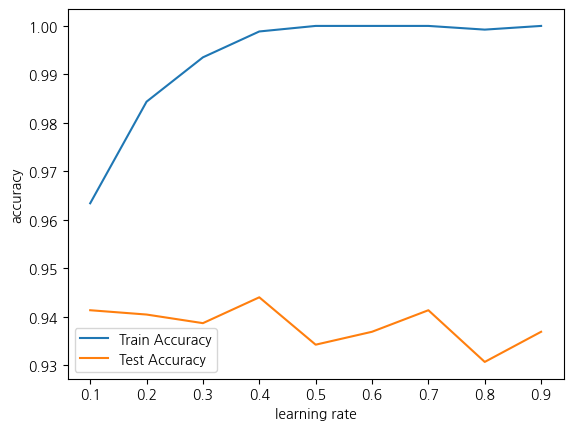

In [14]:
# 그래프 확인
plt.plot(para_lr, train_accuracy, linestyle ="-", label = "Train Accuracy")
plt.plot(para_lr, test_accuracy, linestyle ="-", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("learning rate")
plt.legend()

In [16]:
# 학습률 지정
learning_rate = 0.1

###### n_estimators 파라미터 조정 (트리 수 변경에 따른 모델 성능)

- n_estimators (트리 개수)는 100으로 함

In [27]:
train_accuracy = [] ; test_accuracy = []
para_n_tree = [n_tree * 10 for n_tree in range(1,16)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(n_estimators = v_n_estimators, learning_rate = 0.1 , random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_n = pd.DataFrame()
df_accuracy_n["Estimators"] = para_n_tree
df_accuracy_n["TrainAccuracy"] = train_accuracy
df_accuracy_n["TestAccuracy"] = test_accuracy


In [28]:
# 모델 정확도 확인
df_accuracy_n.round(3)

,Estimators,TrainAccuracy,TestAccuracy
0,10,0.933,0.928
1,20,0.939,0.932
2,30,0.947,0.936
3,40,0.952,0.940
4,50,0.956,0.940
5,60,0.957,0.940
6,70,0.957,0.939
7,80,0.960,0.939
8,90,0.961,0.940
9,100,0.963,0.941


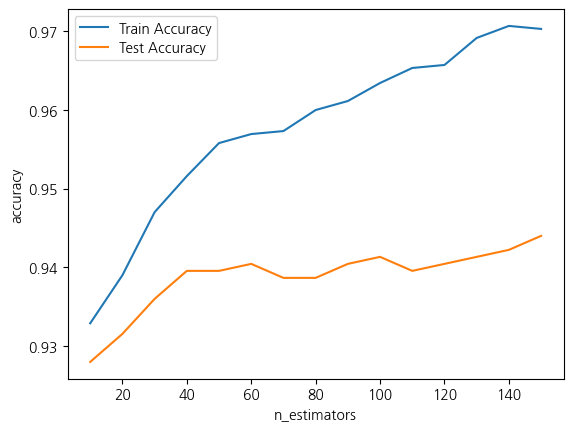

In [29]:
# 그래프 확인
plt.plot(para_n_tree, train_accuracy, linestyle ="-", label = "Train Accuracy")
plt.plot(para_n_tree, test_accuracy, linestyle ="-", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_estimators")
plt.legend()

In [30]:
# 트리 수 지정
n_estimators = 100

###### max_depth 파라미터 조정

- 최대 깊이 6 으로 선정

In [32]:
train_accuracy = [] ; test_accuracy = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier( max_depth = v_max_depth, 
                                n_estimators = 100, learning_rate = 0.1 , random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy


In [33]:
# 모델 정확도 확인
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.936,0.935
1,2,0.951,0.940
2,3,0.963,0.941
3,4,0.979,0.945
4,5,0.990,0.940
5,6,0.998,0.950
6,7,1.000,0.947
7,8,1.000,0.948
8,9,1.000,0.948
9,10,1.000,0.947


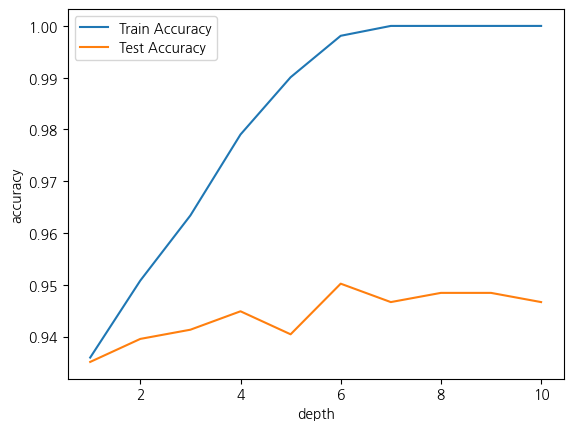

In [34]:
# 그래프 확인
plt.plot(para_depth, train_accuracy, linestyle ="-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle ="-", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("depth")
plt.legend()

In [35]:
max_depth = 6

###### min_samples_split 파라미터 조정

- 스플릿 노드 값 지정하지 않아

In [36]:
train_accuracy = []; test_accuracy = []
para_split = [n_split * 10 for n_split in range(2,11)]

for v_min_samples_split in para_split:
    gb = GradientBoostingClassifier(min_samples_split = v_min_samples_split ,
                                      max_depth = 6, n_estimators = 100, learning_rate = 0.1 , random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [37]:
# 모델 정확도 확인
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,20,0.995,0.942
1,30,0.994,0.940
2,40,0.992,0.945
3,50,0.992,0.942
4,60,0.989,0.947
5,70,0.988,0.943
6,80,0.986,0.944
7,90,0.987,0.945
8,100,0.984,0.944


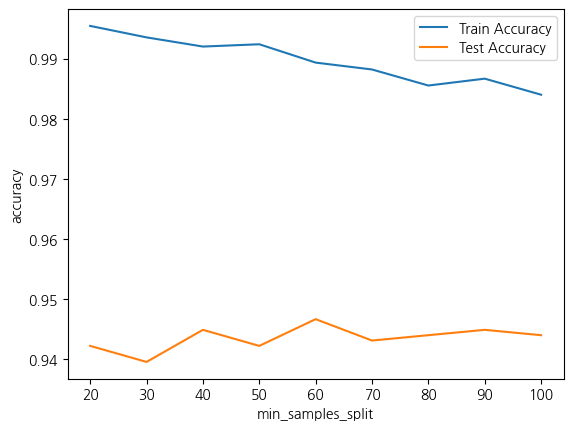

In [38]:
# 그래프 확인
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "-", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min_samples_split")
plt.legend()

###### min_samples_leaf 파라미터 조정

- 잎사귀 노드의 최소 자료 수는 15로 선정

In [39]:
train_accuracy = []; test_accuracy = []
para_leaf = [n_leaf * 5 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(min_samples_leaf = v_min_samples_leaf , 
                                      max_depth = 6, n_estimators = 100, learning_rate = 0.1 , random_state = 1234)
    gb.fit(df_train_x, df_train_y)
    train_accuracy.append(gb.score(df_train_x, df_train_y))
    test_accuracy.append(gb.score(df_test_x, df_test_y))

df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy

In [40]:
# 모델 정확도 확인
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,5,0.998,0.943
1,10,0.995,0.948
2,15,0.991,0.949
3,20,0.990,0.948
4,25,0.987,0.945
5,30,0.984,0.943
6,35,0.984,0.943
7,40,0.982,0.944
8,45,0.982,0.943
9,50,0.978,0.943


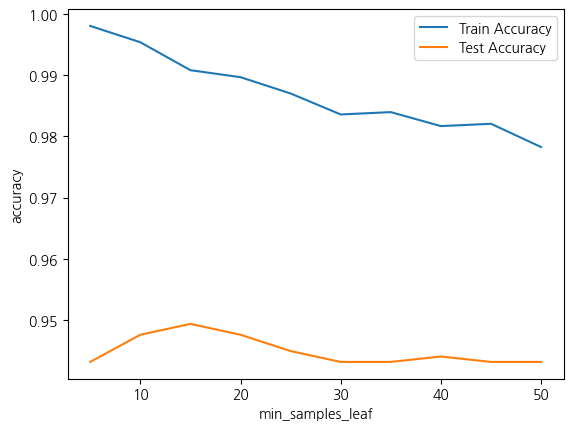

In [42]:
# 그래프 확인
plt.plot(para_leaf, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_leaf, test_accuracy, linestyle = "-", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("min_samples_leaf")
plt.legend()

In [43]:
min_samples_leaf = 15

##### 3. 최종 모델 선정

In [46]:
# 최종 모델 
gb_final = GradientBoostingClassifier(min_samples_leaf = 15 , max_depth = 6, n_estimators = 100, learning_rate = 0.1 , random_state = 1234)
gb_final.fit(df_train_x, df_train_y)

GradientBoostingClassifier(max_depth=6, min_samples_leaf=15, random_state=1234)

In [47]:
y_pred = gb_final.predict(df_test_x)
print("Accuracy on training set: {:.3f}".format(gb_final.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}\n".format(gb_final.score(df_test_x, df_test_y)))
print("Confusion matrix:\n {}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits = 3))

Accuracy on training set: 0.991
Accuracy on test set: 0.949

Confusion matrix:
 [[1020    1]
 [  56   48]]
              precision    recall  f1-score   support

           0      0.948     0.999     0.973      1021
           1      0.980     0.462     0.627       104

    accuracy                          0.949      1125
   macro avg      0.964     0.730     0.800      1125
weighted avg      0.951     0.949     0.941      1125



In [48]:
v_feature_name = df_train_x.columns

# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_final.feature_importances_

# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending = False , inplace = True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.331
6,CLAGE,0.132
2,VALUE,0.105
5,DELINQ,0.096
8,CLNO,0.076
0,LOAN,0.069
3,YOJ,0.048
7,NINQ,0.041
1,MORTDUE,0.037
4,DEROG,0.035


Text(0, 0.5, '설명변수')

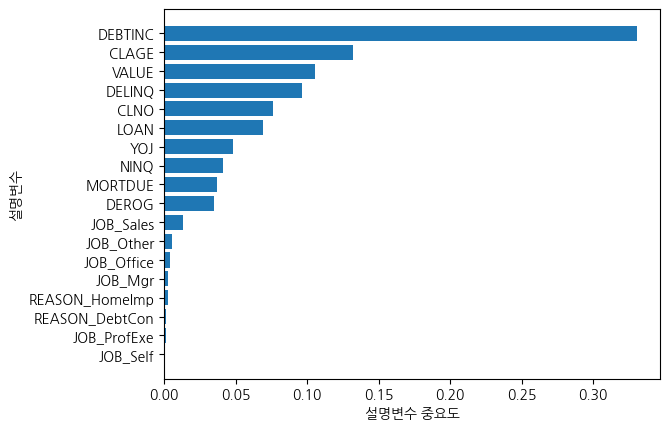

In [49]:
# 설명변수 중요도 그래프
# 중요도가 높은 변수를 상위에 그림
df_importance.sort_values("Importance", ascending = True , inplace = True)
coordinates = range(len(df_importance))
plt.barh( y = coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

### 126p 까지 했음

In [107]:
# GridSearchCV를 이용한 최적 parameter 찾기
estimator = GradientBoostingClassifier(n_estimators=100, random_state = 1234)

param_grid = {"learning_rate": para_lr,
             "max_depth": para_depth,
             "min_samples_leaf": para_leaf}

grid_gb = GridSearchCV(estimator, param_grid, scoring="accuracy" , n_jobs = -1)
grid_gb.fit(df_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_gb.best_estimator_))
print("\nbest prameter: \n{}".format(grid_gb.best_params_))
print("\nbest score: \n{}".format(grid_gb.best_score_.round(3)))

best estimator model: 
GradientBoostingClassifier(learning_rate=0.6000000000000001, max_depth=9,
                           min_samples_leaf=5, random_state=1234)

best prameter: 
{'learning_rate': 0.6000000000000001, 'max_depth': 9, 'min_samples_leaf': 5}

best score: 
0.958


# 서포트 벡터 머신 (159P)

#### 1. 데이터 구성하기

In [51]:
# 기본 옵션으로 모델 생성
svm_uncustomized = SVC(random_state = 1234)
svm_uncustomized.fit(df_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(svm_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(svm_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 0.908
Accuracy on test set: 0.908


In [52]:
# 현재 생성된 모델의 옵션 확인
print(svm_uncustomized.get_params().keys())
print(svm_uncustomized.get_params().values())

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])
dict_values([1.0, False, 200, None, 0.0, 'ovr', 3, 'scale', 'rbf', -1, False, 1234, True, 0.001, False])


###### Cost 파라미터 조정

- 정확도에 별다른 영향을 미치지 않아서 미지정 (Cost 디폴트값 1.0)

In [55]:
train_accuracy = [] ; test_accuracy = []
para_c = [10 **c for c in range(-2,3)]

for v_C in para_c:
    svm = SVC(C = v_C , random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy


In [56]:
# 모델 정확도 확인
df_accuracy_c.round(3)

,C,TrainAccuracy,TestAccuracy
0,0.01,0.908,0.908
1,0.10,0.908,0.908
2,1.00,0.908,0.908
3,10.00,0.909,0.908
4,100.00,0.909,0.909


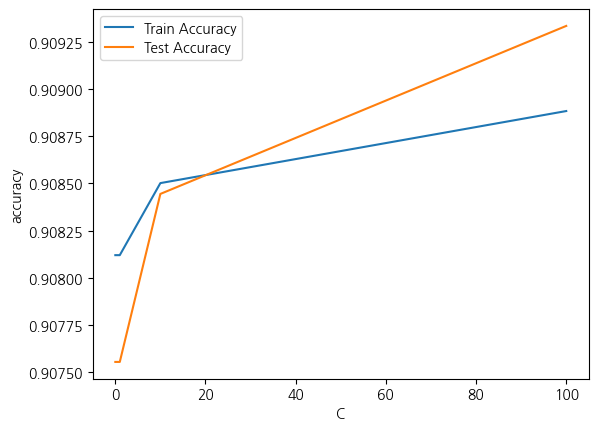

In [57]:
# 그래프 확인
plt.plot(para_c, train_accuracy, linestyle ="-", label = "Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle ="-", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

###### Gamma(데이터의 영향 범위) 파라미터 조정

- 정확도에 별다른 영향을 미치지 않아서 미지정

In [61]:
train_accuracy = [] ; test_accuracy = []
para_gamma = [10 **gamma for gamma in range(-2,2)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma , random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy

In [60]:
# 모델 정확도 확인
df_accuracy_gamma.round(4)

,gamma,TrainAccuracy,TestAccuracy
0,0.01,1.0,0.9076
1,0.10,1.0,0.9076
2,1.00,1.0,0.9076
3,10.00,1.0,0.9076


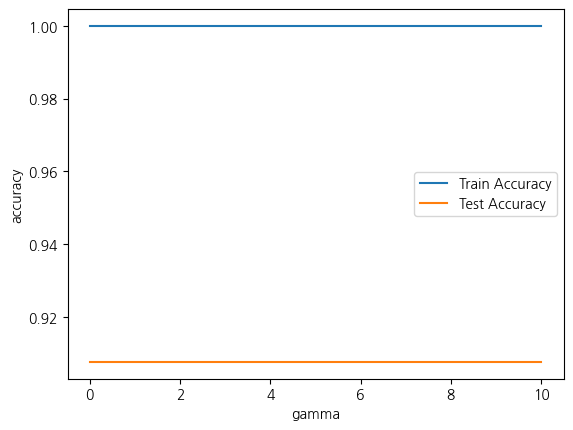

In [63]:
# 그래프 확인
plt.plot(para_gamma, train_accuracy, linestyle ="-", label = "Train Accuracy")
plt.plot(para_gamma, test_accuracy, linestyle ="-", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("gamma")
plt.legend()

###### Standardscaler 설명변수 값의 구간을 동일하게 변경

In [108]:
# scale 변환
v_feature_name = df_train_x.columns

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns = v_feature_name)
df_scaled.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
2,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556
3,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,-1.548549,1.548549,2.618672,-0.446497,-0.828257,-0.574064,-0.131804,-0.189556
4,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556


In [64]:
# 데이터 분할 (7:3)
df_scaled_train_x , df_scaled_test_x = train_test_split(df_scaled , test_size = 0.3 ,random_state = 1234)

print("train data X size: {}".format(df_scaled_train_x.shape))
print("test data X size: {}".format(df_scaled_test_x.shape))

train data X size: (2623, 18)
test data X size: (1125, 18)


#### Scale 조절 후 SVC 모델 재실행

In [66]:
# scale 조정된 데이터로 새로운 모델 생성
svm_scaled = SVC(random_state = 1234)
svm_scaled.fit(df_scaled_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(svm_scaled.score(df_scaled_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(svm_scaled.score(df_scaled_test_x, df_test_y)))

Accuracy on training set: 0.944
Accuracy on test set: 0.935


#### 새로운 SVC 모델 parameter 변경

###### Cost 파라미터 조정

- cost값 1.3 으로 지정

In [67]:
train_accuracy = [] ; test_accuracy = []
para_c = [ c * 0.1 for c in range(1,21)]

for v_C in para_c:
    svm = SVC(C = v_C , random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

df_accuracy_c = pd.DataFrame()
df_accuracy_c["C"] = para_c
df_accuracy_c["TrainAccuracy"] = train_accuracy
df_accuracy_c["TestAccuracy"] = test_accuracy


In [68]:
# 모델 정확도 확인
df_accuracy_c.round(3)

,C,TrainAccuracy,TestAccuracy
0,0.1,0.908,0.908
1,0.2,0.908,0.908
2,0.3,0.908,0.908
3,0.4,0.908,0.908
4,0.5,0.908,0.908
5,0.6,0.908,0.908
6,0.7,0.908,0.908
7,0.8,0.908,0.908
8,0.9,0.908,0.908
9,1.0,0.908,0.908


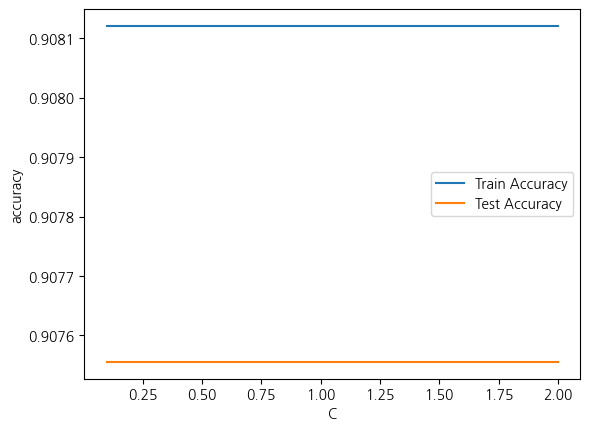

In [69]:
# 그래프 확인
plt.plot(para_c, train_accuracy, linestyle ="-", label = "Train Accuracy")
plt.plot(para_c, test_accuracy, linestyle ="-", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("C")
plt.legend()

###### Gamma 파라미터 조정

- gamma값 0.15로 지정

In [70]:
train_accuracy = [] ; test_accuracy = []
para_gamma = [0.05 * gamma for gamma in range(1,15)]

for v_gamma in para_gamma:
    svm = SVC(gamma = v_gamma , C = 1.3 ,random_state = 1234)
    svm.fit(df_train_x, df_train_y)
    train_accuracy.append(svm.score(df_train_x, df_train_y))
    test_accuracy.append(svm.score(df_test_x, df_test_y))

df_accuracy_gamma = pd.DataFrame()
df_accuracy_gamma["gamma"] = para_gamma
df_accuracy_gamma["TrainAccuracy"] = train_accuracy
df_accuracy_gamma["TestAccuracy"] = test_accuracy

In [71]:
# 모델 정확도 확인
df_accuracy_gamma.round(4)

,gamma,TrainAccuracy,TestAccuracy
0,0.05,1.0,0.9076
1,0.10,1.0,0.9076
2,0.15,1.0,0.9076
3,0.20,1.0,0.9076
4,0.25,1.0,0.9076
5,0.30,1.0,0.9076
6,0.35,1.0,0.9076
7,0.40,1.0,0.9076
8,0.45,1.0,0.9076
9,0.50,1.0,0.9076


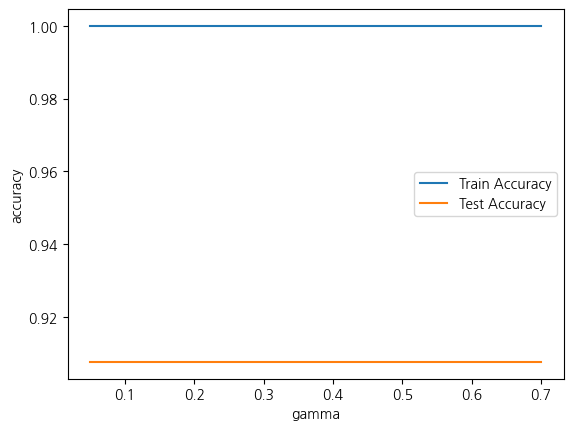

In [72]:
# 그래프 확인
plt.plot(para_gamma, train_accuracy, linestyle ="-", label = "Train Accuracy")
plt.plot(para_gamma, test_accuracy, linestyle ="-", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("gamma")
plt.legend()

##### 3. 최종 모델 선정

In [111]:
# 최종 모델 
svc_final = SVC(gamma = 0.15 , C = 1.3, random_state = 1234)
svc_final.fit(df_scaled_train_x, df_train_y)
y_pred = svc_final.predict(df_scaled_test_x)

print("Accuracy on training set : {:.3f}".format(svc_final.score(df_scaled_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}\n".format(svc_final.score(df_scaled_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits = 3))

Accuracy on training set : 0.976
Accuracy on test set : 0.946

Confusion matrix: 
[[1021    0]
 [  61   43]]
              precision    recall  f1-score   support

           0      0.944     1.000     0.971      1021
           1      1.000     0.413     0.585       104

    accuracy                          0.946      1125
   macro avg      0.972     0.707     0.778      1125
weighted avg      0.949     0.946     0.935      1125



In [112]:
# GridSearchCV를 이용한 최적 parameter 찾기
estimator = SVC(random_state = 1234)

param_grid = {"C": para_c,
             "gamma": para_gamma}

grid_rf = GridSearchCV(estimator, param_grid, scoring="accuracy" , n_jobs = -1)
grid_rf.fit(df_scaled_train_x, df_train_y)
print("best estimator model: \n{}".format(grid_rf.best_estimator_))
print("\nbest prameter: \n{}".format(grid_rf.best_params_))
print("\nbest score: \n{}".format(grid_rf.best_score_.round(3)))

best estimator model: 
SVC(C=2.0, gamma=0.15000000000000002, random_state=1234)

best prameter: 
{'C': 2.0, 'gamma': 0.15000000000000002}

best score: 
0.95


# 인공신경망 연습 (191P)

#### 1. 데이터 구성하기

In [74]:
# 데이터 불러오기
df_raw = pd.read_csv("/home/piai/바탕화면/실습화일/2. Big Data 분석/HMEQ.csv", encoding = "euc-kr")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [75]:
# 결측치 확인
df_raw.isnull().sum(axis = 0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [76]:
# 범주형 변수인 JOB의 결측치는 Other로 입력
df_raw["JOB"].fillna("Other", inplace = True)
# 연속형 데이터는 평균값으로 결측치 대체
df_raw.fillna(df_raw.mean(), inplace = True)

In [77]:
# 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [78]:
# 데이터 구성하기 - 데이터 분할 (7:3)
df_raw_x = df_raw_dummy.drop("BAD", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["BAD"]

df_train_x , df_test_x , df_train_y , df_test_y = train_test_split(\
    df_raw_x , df_raw_y, test_size = 0.3 , random_state = 1234)

print("분할 전 설명변수 데이터 : " , df_raw_x.shape)
print("분할 후 설명변수 데이터 : Train" , df_train_x.shape , "Test" , df_test_x.shape)

분할 전 설명변수 데이터 :  (3748, 18)
분할 후 설명변수 데이터 : Train (2623, 18) Test (1125, 18)


#### 2. 모델 생성

In [80]:
# 기본 옵션으로 모델 생성
nn_uncustomized = MLPClassifier(random_state = 1234)
nn_uncustomized.fit(df_train_x, df_train_y)

print("Accuracy on training set: {:.3f}".format(nn_uncustomized.score(df_train_x, df_train_y)))
print("Accuracy on test set: {:.3f}".format(nn_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 0.722
Accuracy on test set: 0.683


In [81]:
# 현재 생성된 모델의 옵션 확인
print(nn_uncustomized.get_params().keys())
print(nn_uncustomized.get_params().values())

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_fun', 'max_iter', 'momentum', 'n_iter_no_change', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])
dict_values(['relu', 0.0001, 'auto', 0.9, 0.999, False, 1e-08, (100,), 'constant', 0.001, 15000, 200, 0.9, 10, True, 0.5, 1234, True, 'adam', 0.0001, 0.1, False, False])


###### Hidden Layer 파라미터 조정

- Hidden Layer : 은닉층 변경에 따른 모델 성능

In [116]:
train_accuracy = [] ; test_accuracy = []
para_hidden = [ 5 * hidden for hidden in range(1,21)]

print(para_hidden)

for v_hidden in para_hidden:
    #nn = MLPClassifier(hidden_layer_sizes = (v_hidden), random_state = 1234)
    nn = MLPClassifier(hidden_layer_sizes = (v_hidden, v_hidden), random_state = 1234)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden["HiddenLayer"] = para_hidden
df_accuracy_hidden["TrainAccuracy"] = train_accuracy
df_accuracy_hidden["TestAccuracy"] = test_accuracy


[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


In [117]:
# 모델 정확도 확인
df_accuracy_hidden.round(3)

,HiddenLayer,TrainAccuracy,TestAccuracy
0,5,0.908,0.908
1,10,0.840,0.830
2,15,0.908,0.905
3,20,0.219,0.226
4,25,0.830,0.822
5,30,0.903,0.903
6,35,0.907,0.902
7,40,0.850,0.841
8,45,0.907,0.908
9,50,0.909,0.909


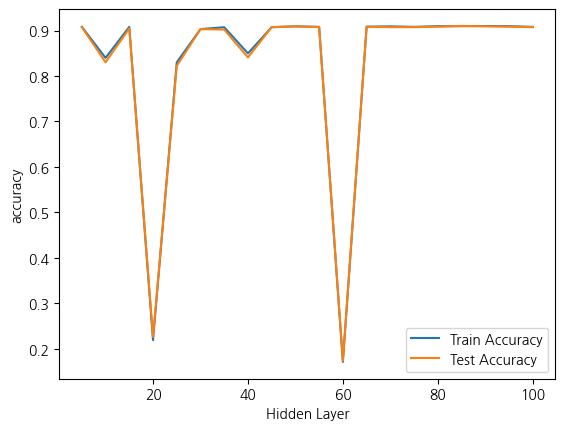

In [118]:
# 그래프 확인
plt.plot(para_hidden, train_accuracy, linestyle ="-", label = "Train Accuracy")
plt.plot(para_hidden, test_accuracy, linestyle ="-", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("Hidden Layer")
plt.legend()

###### Activation 파라미터 조정

- Activation : 활성화 함수에 따른 모델 성능

In [86]:
train_accuracy = []; test_accuracy = []
para_function = ["logistic" , "tanh", "relu"]

for v_function in para_function:
    nn = MLPClassifier(activation = v_function , random_state = 1234)
    nn.fit(df_train_x, df_train_y)
    train_accuracy.append(nn.score(df_train_x, df_train_y))
    test_accuracy.append(nn.score(df_test_x, df_test_y))

df_accuracy_function = pd.DataFrame()
df_accuracy_function["MinSamplesSplit"] = para_function
df_accuracy_function["TrainAccuracy"] = train_accuracy
df_accuracy_function["TestAccuracy"] = test_accuracy

In [87]:
# 모델 정확도 확인
df_accuracy_function.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,logistic,0.908,0.908
1,tanh,0.908,0.908
2,relu,0.722,0.683


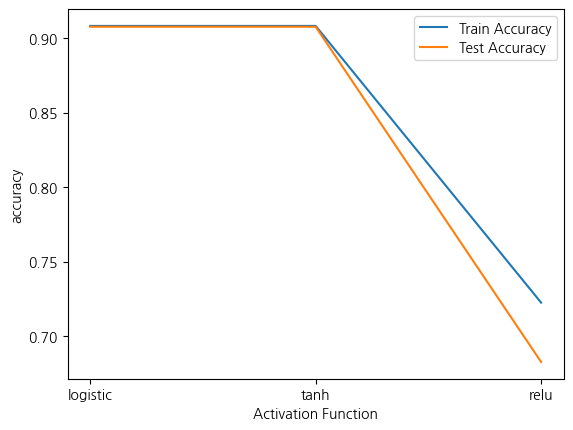

In [88]:
# 그래프 확인
plt.plot(para_function, train_accuracy, linestyle ="-", label = "Train Accuracy")
plt.plot(para_function, test_accuracy, linestyle ="-", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("Activation Function")
plt.legend()

###### Scale 변환

- Standardscaler : 설명변수 scale 변경

In [90]:
# 변수명 저장
v_feature_name = df_train_x.columns

# 데이터 스케일링
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(df_scaled, columns = v_feature_name)
df_scaled.head()

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,-1.548549,1.548549,-0.381873,-0.446497,1.207355,-0.574064,-0.131804,-0.189556
2,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556
3,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,-1.548549,1.548549,2.618672,-0.446497,-0.828257,-0.574064,-0.131804,-0.189556
4,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,-1.548549,1.548549,-0.381873,2.239654,-0.828257,-0.574064,-0.131804,-0.189556


In [91]:
# 데이터 분할
df_scaled_train_x, df_scaled_test_x = train_test_split(df_scaled, test_size = 0.3, random_state = 1234)
print("train data X size : {}".format(df_scaled_train_x.shape))
print("test data Y size : {}".format(df_scaled_test_x.shape))

train data X size : (2623, 18)
test data Y size : (1125, 18)


###### scale 조절 후 MPLClassifier 모델 재실행

- scale이 조정된 데이터로 새로운 모델 생성

In [92]:
nn_scaled = MLPClassifier(random_state = 1234)
nn_scaled.fit(df_scaled_train_x, df_train_y)
print("Accuracy on training set:{:.3f}".format(nn_scaled.score(df_scaled_train_x, df_train_y)))
print("Accuracy on test set:{:.3f}".format(nn_scaled.score(df_scaled_test_x, df_test_y)))

Accuracy on training set:0.971
Accuracy on test set:0.943


###### Hidden Layer 파라미터 조정

- Hidden Layer : 은닉층 변경에 따른 모델 성능 
- 80으로 선정

In [123]:
train_accuracy = [] ; test_accuracy = []
para_hidden = [5 *hidden for hidden in range(1,21)]

print(para_hidden)

for v_hidden in para_hidden:
    nn = MLPClassifier(hidden_layer_sizes = (v_hidden,v_hidden) , random_state = 1234)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))

df_accuracy_hidden = pd.DataFrame()
df_accuracy_hidden["HiddenLayer"] = para_hidden
df_accuracy_hidden["TrainAccuracy"] = train_accuracy
df_accuracy_hidden["TestAccuracy"] = test_accuracy

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


In [124]:
# 모델 정확도 확인
df_accuracy_hidden.round(3)

,HiddenLayer,TrainAccuracy,TestAccuracy
0,5,0.932,0.924
1,10,0.944,0.935
2,15,0.962,0.931
3,20,0.975,0.948
4,25,0.978,0.940
5,30,0.987,0.948
6,35,0.990,0.950
7,40,0.994,0.952
8,45,0.992,0.948
9,50,0.998,0.955


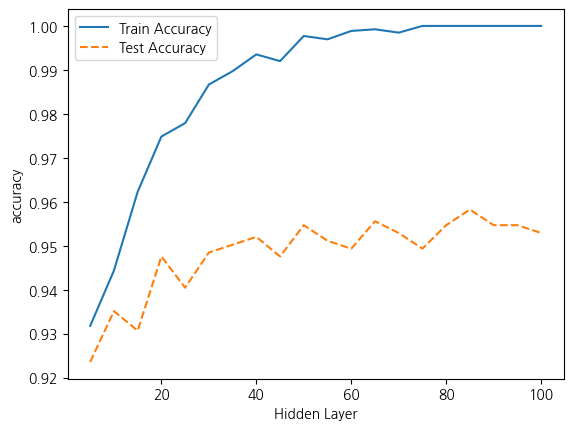

In [125]:
# 모델 정확도 그래프 확인
plt.plot(para_hidden, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_hidden, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy") ; plt.xlabel("Hidden Layer")
plt.legend()

In [138]:
hidden_layer_sizes = 80

###### Activation 파라미터 조정

- Activation : 활성화 함수에 따른 모델 성능
- 활성화 함수 "relu"로 선정

In [150]:
train_accuracy = [] ; test_accuracy = []
para_function = ["logistic", "tanh", "relu"]

for v_function in para_function:
    nn = MLPClassifier(activation = v_function, hidden_layer_sizes = (80,80) , random_state = 1234)
    #nn = MLPClassifier(activation = v_function, hidden_layer_sizes = (80,100,60) , random_state = 1234)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))

df_accuracy_function = pd.DataFrame()
df_accuracy_function["ActivationFunction"] = para_function
df_accuracy_function["TrainAccuracy"] = train_accuracy
df_accuracy_function["TestAccuracy"] = test_accuracy

In [151]:
# 모델 정확도 확인
df_accuracy_function.round(3)

,ActivationFunction,TrainAccuracy,TestAccuracy
0,logistic,0.937,0.933
1,tanh,0.999,0.952
2,relu,1.000,0.955


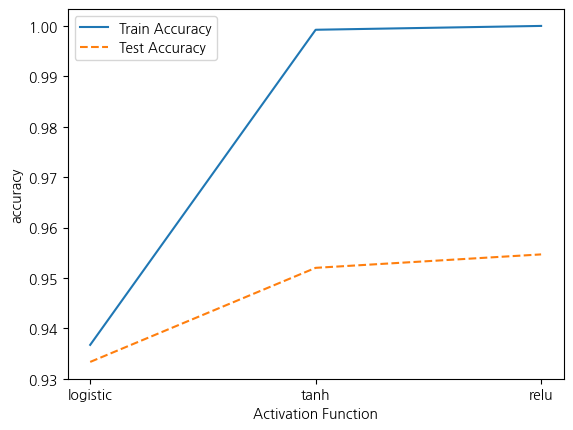

In [152]:
# 모델 정확도 그래프 확인
plt.plot(para_function, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_function, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy") ; plt.xlabel("Activation Function")
plt.legend()

In [153]:
activation = "relu"

###### Solver 파라미터 조정

- solver : 가중치 최적화 변경에 따른 모델 성능
- 가중치 방식은 adam으로 선정

In [154]:
train_accuracy = [] ; test_accuracy = []
para_solver = ["lbfgs", "sgd", "adam"]

for v_solver in para_solver:
    nn = MLPClassifier(solver = v_solver, activation = "relu" , hidden_layer_sizes = (80,80) , random_state = 1234)
    #nn = MLPClassifier(activation = v_function, hidden_layer_sizes = (80,100,60) , random_state = 1234)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))

df_accuracy_solver = pd.DataFrame()
df_accuracy_solver["Solver"] = para_solver
df_accuracy_solver["TrainAccuracy"] = train_accuracy
df_accuracy_solver["TestAccuracy"] = test_accuracy

In [155]:
# 모델 정확도 확인
df_accuracy_solver.round(3)

,Solver,TrainAccuracy,TestAccuracy
0,lbfgs,1.000,0.948
1,sgd,0.934,0.928
2,adam,1.000,0.955


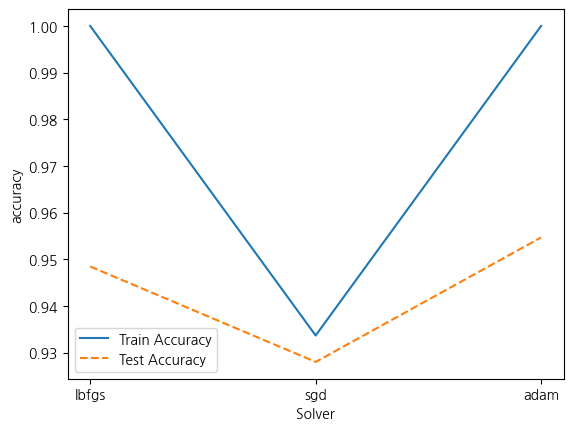

In [156]:
# 모델 정확도 그래프 확인
plt.plot(para_solver, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_solver, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy") ; plt.xlabel("Solver")
plt.legend()

###### Mini batch 파라미터 조정

- Mini Batch 변경에 따른 모델 성능 
- 배치 사이즈는 100으로 설정

In [157]:
train_accuracy = [] ; test_accuracy = []
para_batch = [20 * batch for batch in range(1,10)]

print(para_batch)

for v_batch in para_batch:
    nn = MLPClassifier(batch_size = v_batch, solver = "adam", activation = "relu" ,
                       hidden_layer_sizes = (80,80) , random_state = 1234)
    #nn = MLPClassifier(activation = v_function, hidden_layer_sizes = (80,100,60) , random_state = 1234)
    nn.fit(df_scaled_train_x, df_train_y)
    train_accuracy.append(nn.score(df_scaled_train_x, df_train_y))
    test_accuracy.append(nn.score(df_scaled_test_x, df_test_y))

df_accuracy_batch = pd.DataFrame()
df_accuracy_batch["Mini Batch"] = para_batch
df_accuracy_batch["TrainAccuracy"] = train_accuracy
df_accuracy_batch["TestAccuracy"] = test_accuracy

[20, 40, 60, 80, 100, 120, 140, 160, 180]


In [158]:
# 모델 정확도 확인
df_accuracy_batch.round(3)

,Mini Batch,TrainAccuracy,TestAccuracy
0,20,1.0,0.959
1,40,1.0,0.956
2,60,1.0,0.950
3,80,1.0,0.952
4,100,1.0,0.952
5,120,1.0,0.953
6,140,1.0,0.953
7,160,1.0,0.954
8,180,1.0,0.956


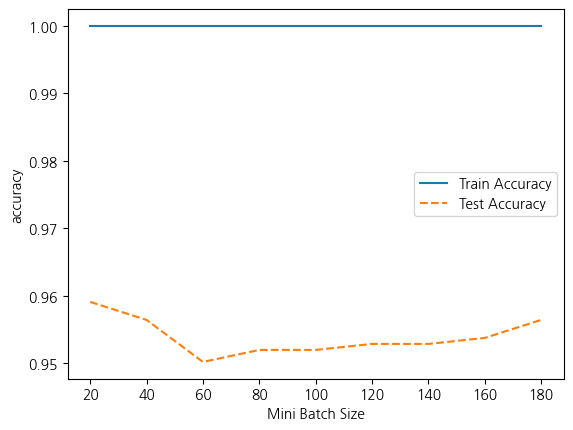

In [160]:
# 모델 정확도 그래프 확인
plt.plot(para_batch, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_batch, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy") ; plt.xlabel("Mini Batch Size")
plt.legend()

In [163]:
# 최종 모델 
nn_final = MLPClassifier(hidden_layer_sizes = (80,80), activation="relu", solver = "adam" , batch_size = 100,
                        random_state = 1234)
nn_final.fit(df_scaled_train_x, df_train_y)
y_pred = nn_final.predict(df_scaled_test_x)

print("Accuracy on training set : {:.3f}".format(nn_final.score(df_scaled_train_x, df_train_y)))
print("Accuracy on test set : {:.3f}\n".format(nn_final.score(df_scaled_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits = 3))

Accuracy on training set : 1.000
Accuracy on test set : 0.952

Confusion matrix: 
[[1018    3]
 [  51   53]]
              precision    recall  f1-score   support

           0      0.952     0.997     0.974      1021
           1      0.946     0.510     0.662       104

    accuracy                          0.952      1125
   macro avg      0.949     0.753     0.818      1125
weighted avg      0.952     0.952     0.945      1125



# KNN 연습 (219P) 

#### 1. 데이터 구성하기

In [94]:
# 데이터 불러오기
df_raw = pd.read_csv("/home/piai/바탕화면/실습화일/2. Big Data 분석/HMEQ.csv", encoding = "euc-kr")
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [95]:
# 결측치 확인
df_raw.isnull().sum(axis = 0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [96]:
# 범주형 변수인 JOB의 결측치는 Other로 입력
df_raw["JOB"].fillna("Other", inplace = True)
# 연속형 데이터는 평균값으로 결측치 대체
df_raw.fillna(df_raw.mean(), inplace = True)

In [97]:
# 더미변수 생성
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [98]:
# 데이터 구성하기 - 데이터 분할 (7:3)
df_raw_x = df_raw_dummy.drop("BAD", axis = 1, inplace = False)
df_raw_y = df_raw_dummy["BAD"]

df_train_x , df_test_x , df_train_y , df_test_y = train_test_split(\
    df_raw_x , df_raw_y, test_size = 0.3 , random_state = 1234)

print("분할 전 설명변수 데이터 : " , df_raw_x.shape)
print("분할 후 설명변수 데이터 : Train" , df_train_x.shape , "Test" , df_test_x.shape)

분할 전 설명변수 데이터 :  (3748, 18)
분할 후 설명변수 데이터 : Train (2623, 18) Test (1125, 18)


#### 2. 모델 생성

In [101]:
# 기본 옵션으로 모델생성
knn_uncutomized = KNeighborsClassifier()
knn_uncutomized.fit(df_train_x, df_train_y)

print("Accuracy on training set:{:.3f}".format(knn_uncutomized.score(df_train_x, df_train_y)))
print("Accuracy on test set:{:.3f}".format(knn_uncutomized.score(df_test_x, df_test_y)))


Accuracy on training set:0.916
Accuracy on test set:0.908


In [103]:
# 현재 생성된 모델의 옵션 확인
print(knn_uncutomized.get_params().keys())
print(knn_uncutomized.get_params().values())

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])
dict_values(['auto', 30, 'minkowski', None, None, 5, 2, 'uniform'])


###### n_neighbors (이웃 수) 파라미터 조정

- n_neighbors는 4로 지정

In [104]:
train_accuracy = []; test_accuracy = []
para_n_neighbors = [i for i in range(1,16)]

for v_n_neighbors in para_n_neighbors:
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))

df_accuracy_neighbors = pd.DataFrame()
df_accuracy_neighbors["Neighbors"] = para_n_neighbors
df_accuracy_neighbors["TrainAccuracy"] = train_accuracy
df_accuracy_neighbors["TestAccuracy"] = test_accuracy
df_accuracy_neighbors.round(3)

,Neighbors,TrainAccuracy,TestAccuracy
0,1,1.000,0.877
1,2,0.928,0.912
2,3,0.929,0.913
3,4,0.916,0.914
4,5,0.916,0.908
5,6,0.913,0.911
6,7,0.913,0.912
7,8,0.910,0.912
8,9,0.911,0.913
9,10,0.909,0.910


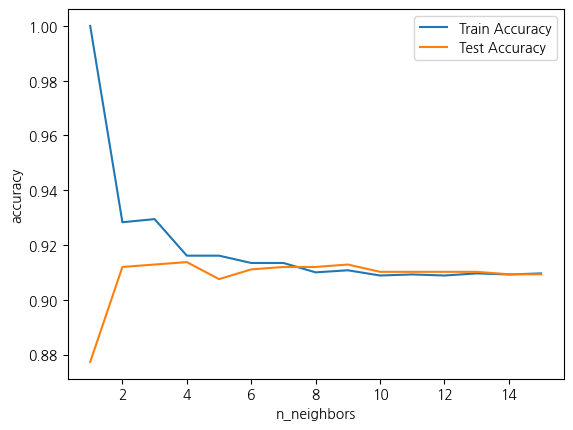

In [105]:
# 모델 정확도 그래프 확인
plt.plot(para_n_neighbors, train_accuracy, linestyle = "-" , label = "Train Accuracy")
plt.plot(para_n_neighbors, test_accuracy, linestyle = "-" , label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_neighbors")
plt.legend()

In [106]:
n_neighbors = 4

###### 가중치 별 이웃 수 증가에 따른 정확도 변화

- 가중치는 uniform 선택

In [ ]:
train_accuracy = []; test_accuracy = []

para_n_neighbors = [i for i in range(1,11)] * 2

para_weights = (["uniform"]) * 10 + (["distance"] * 10) 

for (v_n_neighbors, v_weights) in zip(para_n_neighbors, para_weights):
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors , weights = v_weights)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))

df_accuracy_weights = pd.DataFrame()
df_accuracy_weights["Neighbors"] = para_n_neighbors
df_accuracy_weights["Weights"] = para_weights
df_accuracy_weights["TrainAccuracy"] = train_accuracy
df_accuracy_weights["TestAccuracy"] = test_accuracy
df_accuracy_weights.round(3)

In [182]:
df_accuracy_weights_pivot = df_accuracy_weights.pivot(index = "Neighbors" , columns = "Weights" ,
                                                     values = ["TrainAccuracy", "TestAccuracy"])
df_accuracy_weights_pivot

TrainAccuracy           TestAccuracy          
Weights        distance   uniform     distance   uniform
Neighbors                                               
1                   1.0  1.000000     0.877333  0.877333
2                   1.0  0.928326     0.877333  0.912000
3                   1.0  0.929470     0.912000  0.912889
4                   1.0  0.916127     0.913778  0.913778
5                   1.0  0.916127     0.912889  0.907556
6                   1.0  0.913458     0.912889  0.911111
7                   1.0  0.913458     0.912889  0.912000
8                   1.0  0.910027     0.913778  0.912000
9                   1.0  0.910789     0.914667  0.912889
10                  1.0  0.908883     0.914667  0.910222

In [183]:
level0 =df_accuracy_weights_pivot.columns.get_level_values(0)
level1 =df_accuracy_weights_pivot.columns.get_level_values(1)
df_accuracy_weights_pivot.columns = level0 + "_" + level1
df_accuracy_weights_pivot.head()

,TrainAccuracy_distance,TrainAccuracy_uniform,TestAccuracy_distance,TestAccuracy_uniform
Neighbors,,,,
1,1.0,1.000000,0.877333,0.877333
2,1.0,0.928326,0.877333,0.912000
3,1.0,0.929470,0.912000,0.912889
4,1.0,0.916127,0.913778,0.913778
5,1.0,0.916127,0.912889,0.907556


<Axes: xlabel='Neighbors'>

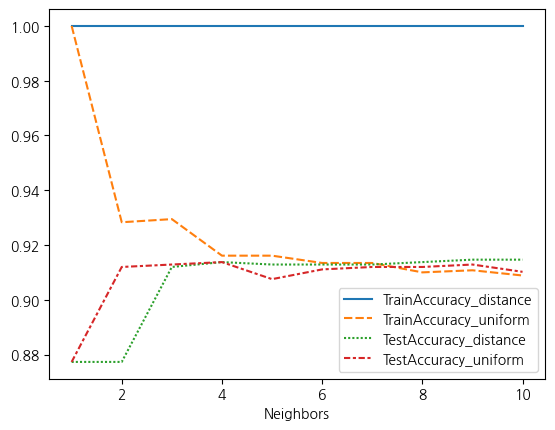

In [184]:
sns.lineplot(data = df_accuracy_weights_pivot)

In [185]:
weights = "uniform"

###### 거리 계산 방법별 이웃 수 증가에 따른 정확도 변화

- 유클리디안과 맨허튼 방법 둘 다 큰 차이 없음

In [190]:
train_accuracy = []; test_accuracy = []

para_n_neighbors = [i for i in range(1,11)] * 2

para_metric = (["euclidean"]) * 10 + (["manhattan"] * 10) 

for (v_n_neighbors, v_metric) in zip(para_n_neighbors, para_metric):
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors , metric = v_metric , weights = "uniform")
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))

df_accuracy_metric = pd.DataFrame()
df_accuracy_metric["Neighbors"] = para_n_neighbors
df_accuracy_metric["Metric"] = para_metric
df_accuracy_metric["TrainAccuracy"] = train_accuracy
df_accuracy_metric["TestAccuracy"] = test_accuracy
df_accuracy_metric.round(3)

,Neighbors,Metric,TrainAccuracy,TestAccuracy
0,1,euclidean,1.000,0.877
1,2,euclidean,0.928,0.912
2,3,euclidean,0.929,0.913
3,4,euclidean,0.916,0.914
4,5,euclidean,0.916,0.908
5,6,euclidean,0.913,0.911
6,7,euclidean,0.913,0.912
7,8,euclidean,0.910,0.912
8,9,euclidean,0.911,0.913
9,10,euclidean,0.909,0.910


In [191]:
df_accuracy_metric_pivot = df_accuracy_metric.pivot(index = "Neighbors" , columns = "Metric" ,
                                                     values = ["TrainAccuracy", "TestAccuracy"])

level0 =df_accuracy_metric_pivot.columns.get_level_values(0)
level1 =df_accuracy_metric_pivot.columns.get_level_values(1)
df_accuracy_metric_pivot.columns = level0 + "_" + level1
df_accuracy_metric_pivot.head()

,TrainAccuracy_euclidean,TrainAccuracy_manhattan,TestAccuracy_euclidean,TestAccuracy_manhattan
Neighbors,,,,
1,1.000000,1.000000,0.877333,0.877333
2,0.928326,0.926420,0.912000,0.913778
3,0.929470,0.929470,0.912889,0.912000
4,0.916127,0.917652,0.913778,0.912000
5,0.916127,0.915745,0.907556,0.907556


<Axes: xlabel='Neighbors'>

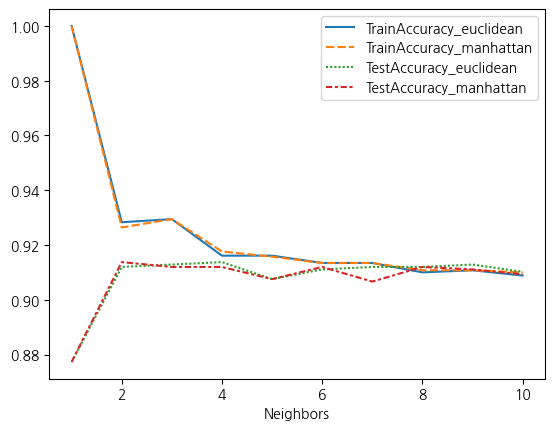

In [192]:
sns.lineplot(data = df_accuracy_metric_pivot)

###### 결론 도출

In [193]:
# 최종 모델
knn_model = KNeighborsClassifier(n_neighbors = 4 , weights = "uniform", metric = "euclidean")
knn_model.fit(df_train_x, df_train_y)
y_pred = knn_model.predict(df_test_x)

print("train data accuracy: {0:.3f}".format(knn_model.score(df_train_x, df_train_y)))
print("test data accuracy: {0:.3f}".format(knn_model.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))
print(classification_report(df_test_y, y_pred, digits = 3))

train data accuracy: 0.916
test data accuracy: 0.914
Confusion matrix: 
[[1018    3]
 [  94   10]]
              precision    recall  f1-score   support

           0      0.915     0.997     0.955      1021
           1      0.769     0.096     0.171       104

    accuracy                          0.914      1125
   macro avg      0.842     0.547     0.563      1125
weighted avg      0.902     0.914     0.882      1125

